## Initialization
First, import the packages and initialize things we plan to use

In [5]:
# Import packages
import keras,sklearn
import keras.backend as kb
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import pylab as pl
from scipy import stats, math, interpolate
from scipy import optimize
from scipy.interpolate import CubicSpline

import random

import sys

#import complex ode solver for Sch. Equation
#from odeintw import odeintw
import odeintw as oiw
# Set seed
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)



Using TensorFlow backend.


## Define functions to create the dataset
Here, we create some functions that make generating greatly varying datasets easy to do

In [184]:
def calcPerfData(Bx, By, Bz, psi0, tvec):
    # Determine number of steps
    steps = len(tvec)
    
    # Declare pauli matrices
    sigmax = np.zeros([2,2],dtype='complex')
    sigmay = np.zeros([2,2],dtype='complex')
    sigmaz = np.zeros([2,2],dtype='complex')

    sigmax[0,1] = 1.0
    sigmax[1,0] = 1.0

    sigmaz[0,0] = 1.0
    sigmaz[1,1] = -1.0

    sigmay[0,1] = -1.0*1j
    sigmay[1,0] = 1.0*1j
    
    # Declare states to project to
    psix = np.zeros([2,1],dtype='complex')
    psiy = np.zeros([2,1],dtype='complex')
    psiz = np.zeros([2,1],dtype='complex')

    psix[0] = 1/np.sqrt(2)
    psix[1] = 1/np.sqrt(2)

    psiy[0] = 1/np.sqrt(2)
    psiy[1] = 1j/np.sqrt(2)

    psiz[0] = 1
    psiz[1] = 0
    
    # Create the derivative as -i*H, Hamiltonian
    def evolve(psi,t):
        dpsi =  -1j * np.dot( Bx(t)*sigmax + By(t)*sigmay + Bz(t)*sigmaz, psi)
        return dpsi
    
    # Integrate to get the solution
    psi0use       = np.reshape(np.transpose(psi0),2)
    solution      = np.zeros([steps,2],dtype='complex')
    solution[:,:] = oiw.odeintw(evolve,psi0use,tspace)
    
    # Initialize the output
    probabilities = np.zeros([steps,3])
    
    # Get the probabilities by dotting the solution (a stepsx2) into the states (a 2x1) for each operator
    probabilities[:,0] = np.square(np.abs(np.dot(np.conj(solution), psix))).reshape(steps)
    probabilities[:,1] = np.square(np.abs(np.dot(np.conj(solution), psiy))).reshape(steps)
    probabilities[:,2] = np.square(np.abs(np.dot(np.conj(solution), psiz))).reshape(steps)
    
    expectations = 2*probabilities-1
    return probabilities, expectations





def calcNoisyData(probabilities, Nmeas, meanNorm, stdNorm):
    if Nmeas > 0:
        expectNoisy = 2*np.random.binomial(Nmeas, probabilities)/Nmeas - 1
    else:
        expectNoisy = 2*probabilities - 1
        
    expectNoisy = expectNoisy + stdNorm*np.random.randn(np.shape(probabilities)[0],3) + meanNorm
    return expectNoisy





def createDataSet(Ndata, Bx, By, Bz, psi0mat, tspace, noiseData, noiseLabel=np.array([0,0,0])):
    # Get Parameters and such
    #Ndata = np.shape(psi0mat)[1] # Psi0 is always a 2xN
    steps = len(tspace)
    
    NmeasLabl  = noiseLabel[0]
    meanLabl   = noiseLabel[1]
    stdLabl    = noiseLabel[2]
    
    NmeasData  = noiseData[0]
    meanData   = noiseData[1]
    stdData    = noiseData[2]
    
    # Initialize output
    dataMat    = np.zeros((Ndata, steps, 3))
    lablMat    = np.zeros((Ndata, steps, 3))
    
    # Loop over running ODE solver
    for i in range(Ndata):
        # Solve the ODE and get results
        probabilities, expectations = calcPerfData(Bx, By, Bz, psi0mat, tspace)
        
        # Add noise to the data and labels and insert into output
        dataMat[i,:,:]  = calcNoisyData(probabilities, NmeasData, meanData, stdData)
        lablMat[i,:,:]  = calcNoisyData(probabilities, NmeasLabl, meanLabl, stdLabl)
        
    return dataMat, lablMat

        
    

    
        

## Generate data set
Next, generate a data set by integrating the Schrodinger equation and adding noise to get high noise inputs and low noise/noise free labels

In [239]:
# stuff for dataset here
## Input parameters

Ntrain = 30             # Number of datapoints
Ntest  = 10
steps  = 1000  # Number of time steps

T = 10           # Total time of simulation
tspace = np.linspace(0,T,steps)

noiseDataUse = np.array([0,0,.1])   # N_sim_measurement, noiseMean, noiseStddev.
noiseLablUse = np.array([0,0,0])      # N_sim_measurement, noiseMean, noiseStddev.


# Define the fields as functions of time
def Bx(t):
    return 2*math.pi/(4*3)*np.sin(2*np.pi/5*t)
def By(t):
    return 2*math.pi/(4*3)*np.cos(2*np.pi/5*t)
def Bz(t):
    return 0

psi0mat = np.ones([2,1],dtype='complex')
psi0mat[1,:] = np.zeros([1,1],dtype='complex')
#intial wavefunction declaration
#psi0mat = np.zeros((2,N),dtype='complex')
#for i in range(N):    
#    psi0mat[0,i] = np.random.normal(scale=1)
#    psi0mat[1,i] = np.random.normal(scale=1)
#    psi0mat[:,i] = psi0mat[:,i]/np.linalg.norm(psi0mat[:,i])

print(psi0mat)

dataMatTrn, lablMatTrn = createDataSet(Ntrain, Bx, By, Bz, psi0mat, tspace, noiseData=noiseDataUse, noiseLabel=noiseLablUse )
dataMatTst, lablMatTst = createDataSet(Ntest,  Bx, By, Bz, psi0mat, tspace, noiseData=noiseDataUse, noiseLabel=noiseLablUse )


[[1.+0.j]
 [0.+0.j]]


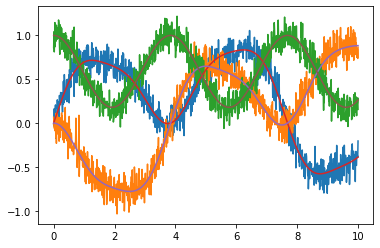

In [240]:
plt.plot(tspace, dataMatTrn[0,:,0])
plt.plot(tspace, dataMatTrn[0,:,1])
plt.plot(tspace, dataMatTrn[0,:,2])

plt.plot(tspace, lablMatTrn[0,:,0])
plt.plot(tspace, lablMatTrn[0,:,1])
plt.plot(tspace, lablMatTrn[0,:,2])


## Preprocess data
shape as necessary, divide into test and train, etc.

In [6]:
#stuff for processing data

## Define the model
Now, define the model architecture

In [7]:
# stuff for defining the model

## Compile the model
Set the loss function and optimizer and compile the model

In [8]:
# stuff for compiling model

## Train the Model
Input the training parameters and watch it train

In [9]:
# Stuff for training the model

## Evaluate the model
Evaluate the model on test data and look at some output results